# Setup

In [1]:
# Imports
%matplotlib inline
import matplotlib as mpl
import matplotlib.patches as patches
import matplotlib.patheffects as PathEffects
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import shutil
import os

import utils

from classes import Tetraloop, Chain, Fragment
from collections import Counter, OrderedDict
from copy import deepcopy
from itertools import combinations
from math import log
from pathlib import Path
from pprint import pprint
from PyPDF2 import PdfWriter

In [67]:
# Paths
CLUSTERS_DIR = Path('../../all_clusters/')
STRUCTURES_DIR = Path('../../all_structures/')
DATA_DIR = Path('data/')
FRAGMENTS_DIR = Path('data/fragments/')
FRAGMENTS_RANGE = range(8, 25, 2)
FIGURES_DIR = Path('figures/')
TRAINING_DATA_DIR = Path('training_data/homology_reduced/')
METADATA = pd.read_csv(DATA_DIR/'RCSB_metadata.csv', header=[1]).dropna(axis=1, how='all')

# Create figures directory if none exists
if not FIGURES_DIR.exists():
    FIGURES_DIR.mkdir(parents=True, exist_ok=True)

In [3]:
# Load all data

# Tetraloops
tloops = utils.load(DATA_DIR/'tloops.pickle')

# Annotated chains
chains_annotated = utils.load(DATA_DIR/'chains_annotated.pickle')

# Fragments
for i in FRAGMENTS_RANGE:
    globals()[f"fragments_{i}"] = utils.load(FRAGMENTS_DIR/f"fragments_{i}.pickle")
fragments = [val for key, val in globals().items() if "fragments" in key]

#// tloops_raw = utils.load(data_dir/'tloops_raw.pickle')
#// tloops_filtered = utils.load(data_dir/'tloops_filtered.pickle')

#// chains_annotated_raw = utils.load(data_dir/'chains_annotated_raw.pickle')
#// chains_annotated_filtered = utils.load(data_dir/'chains_annotated_filtered.pickle')

#// fragments_8_raw = utils.load(fragments_dir/'fragments_8_raw.pickle')
#// ...
#// fragments_raw = [fragments_8_raw, ...]

#// fragments_8_filtered = utils.load(fragments_dir/'fragments_8_filtered.pickle')
#// ...
#// fragments_filtered = [fragments_8_filtered, ...]

In [4]:
# General functions

def get_pdb_ids(data, unique=False, clusters=None):
    if clusters: pdb_ids = [i.pdb_id for i in data if i.clust_id in clusters]
    else: pdb_ids = [i.pdb_id for i in data]
    if unique: return set(pdb_ids)
    else: return pdb_ids


def get_seqs(data, unique=False, clusters=None):
    if clusters: seqs = [i.res_seq for i in data if i.clust_id in clusters]
    else: seqs = [i.res_seq for i in data]
    if unique: return set(seqs)
    else: return seqs


def get_counter_dict(data):
    return OrderedDict(Counter(data).most_common())

In [5]:
# pyplot config

COLORS = plt.cm.Set2.colors
HATCHES = ["//", "\\\\", ".."  , "++" , "-" , "|" , "x", "*" ]

plt.style.use('seaborn-darkgrid')
custom_cycler = (plt.cycler(hatch=HATCHES) + plt.cycler(color=COLORS))
plt.rcParams["axes.prop_cycle"] = custom_cycler
plt.rcParams['hatch.linewidth'] = 0.5
plt.rcParams['hatch.color'] = 'w'

# Metadata

In [5]:
# Functions

def get_structure(pdb_id: str):
    matching_rows = METADATA[METADATA['Entry ID'] == pdb_id.upper()]
    if not matching_rows.empty:
        return matching_rows.iloc[0]["Stucture Keywords"]
    else:
        return ""


def get_organisms(pdb_id: str):
    organisms = []
    start_loc = METADATA.index[METADATA['Entry ID'] == pdb_id.upper()]
    if not start_loc.any(): return set(["N/A"])
    start_idx = start_loc.tolist()[0]
    for index, row in METADATA.iloc[start_idx:].iterrows():
        if row['Entry ID'] == pdb_id.upper() or pd.isna(row['Entry ID']):
            organisms += [str(row["Source Organism"])]
        else: break
    return set([i for i in organisms if i != "nan"])

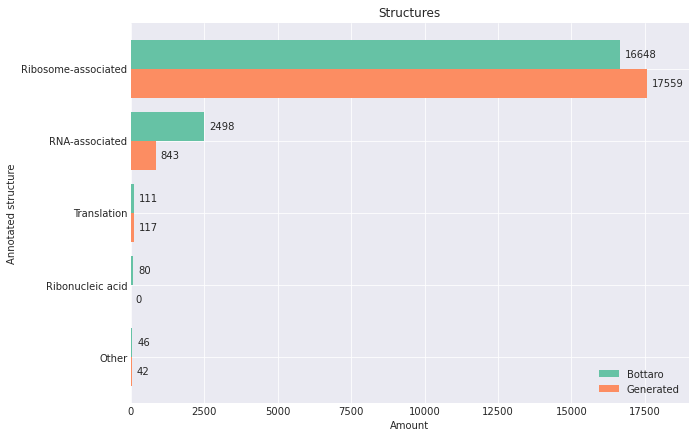

In [21]:
# Structures

# Get structures
bottaro_structures = [get_structure(i).lower() for i in get_pdb_ids(tloops)]
generated_structures = [get_structure(i).lower() for i in get_pdb_ids(fragments_8, clusters=list(range(1,45)))]

fig, ax = plt.subplots(figsize=(10, 7))
fig.subplots_adjust(wspace=0.3)
fig.tight_layout

bar_height = 0.4

# Structures #! These are all supposed to be tetraloops, better to exclude?

ax.set_title("Structures")
ax.set_ylabel("Annotated structure")
ax.set_xlabel("Amount")
ax.set_xlim([0, 19000])

other_limit = 20

# Bottaro tetraloops
bottaro_data = get_counter_dict(bottaro_structures)
bottaro_merged = {"Ribosome-associated": 0, "RNA-associated": 0, "Other": 0}
for structure, count in bottaro_data.items():
    if "ribosome" in structure: bottaro_merged["Ribosome-associated"] += count
    elif "rna" in structure:    bottaro_merged["RNA-associated"] += count
    elif count < other_limit:   bottaro_merged["Other"] += count
    else:                       bottaro_merged[structure.capitalize()] = count
bottaro_merged = dict(sorted(bottaro_merged.items(), key=lambda item: item[1]))
bottaro_merged = {'Other': bottaro_merged.pop('Other'), **bottaro_merged}

y_pos = np.arange(len(bottaro_merged))
bar = ax.barh(y_pos, bottaro_merged.values(), height=bar_height, align="edge")
ax.bar_label(bar, padding=5)
_ = ax.set_yticks(y_pos, labels=bottaro_merged.keys())

# Generated tetraloops
generated_data = get_counter_dict(generated_structures)
generated_merged = dict(zip(bottaro_merged.keys(), np.zeros(len(bottaro_merged))))
for structure, count in generated_data.items():
    if "ribosome" in structure: generated_merged["Ribosome-associated"] += count
    elif "rna" in structure:    generated_merged["RNA-associated"] += count
    elif count < other_limit:   generated_merged["Other"] += count
    else:                       generated_merged[structure.capitalize()] = count

bar = ax.barh(y_pos, generated_merged.values(), height=-bar_height, align="edge")
ax.bar_label(bar, padding=5)

ax.legend(labels=["Bottaro", "Generated"], loc="lower right")

fig.savefig(FIGURES_DIR/"structures.png", bbox_inches='tight', dpi=300)

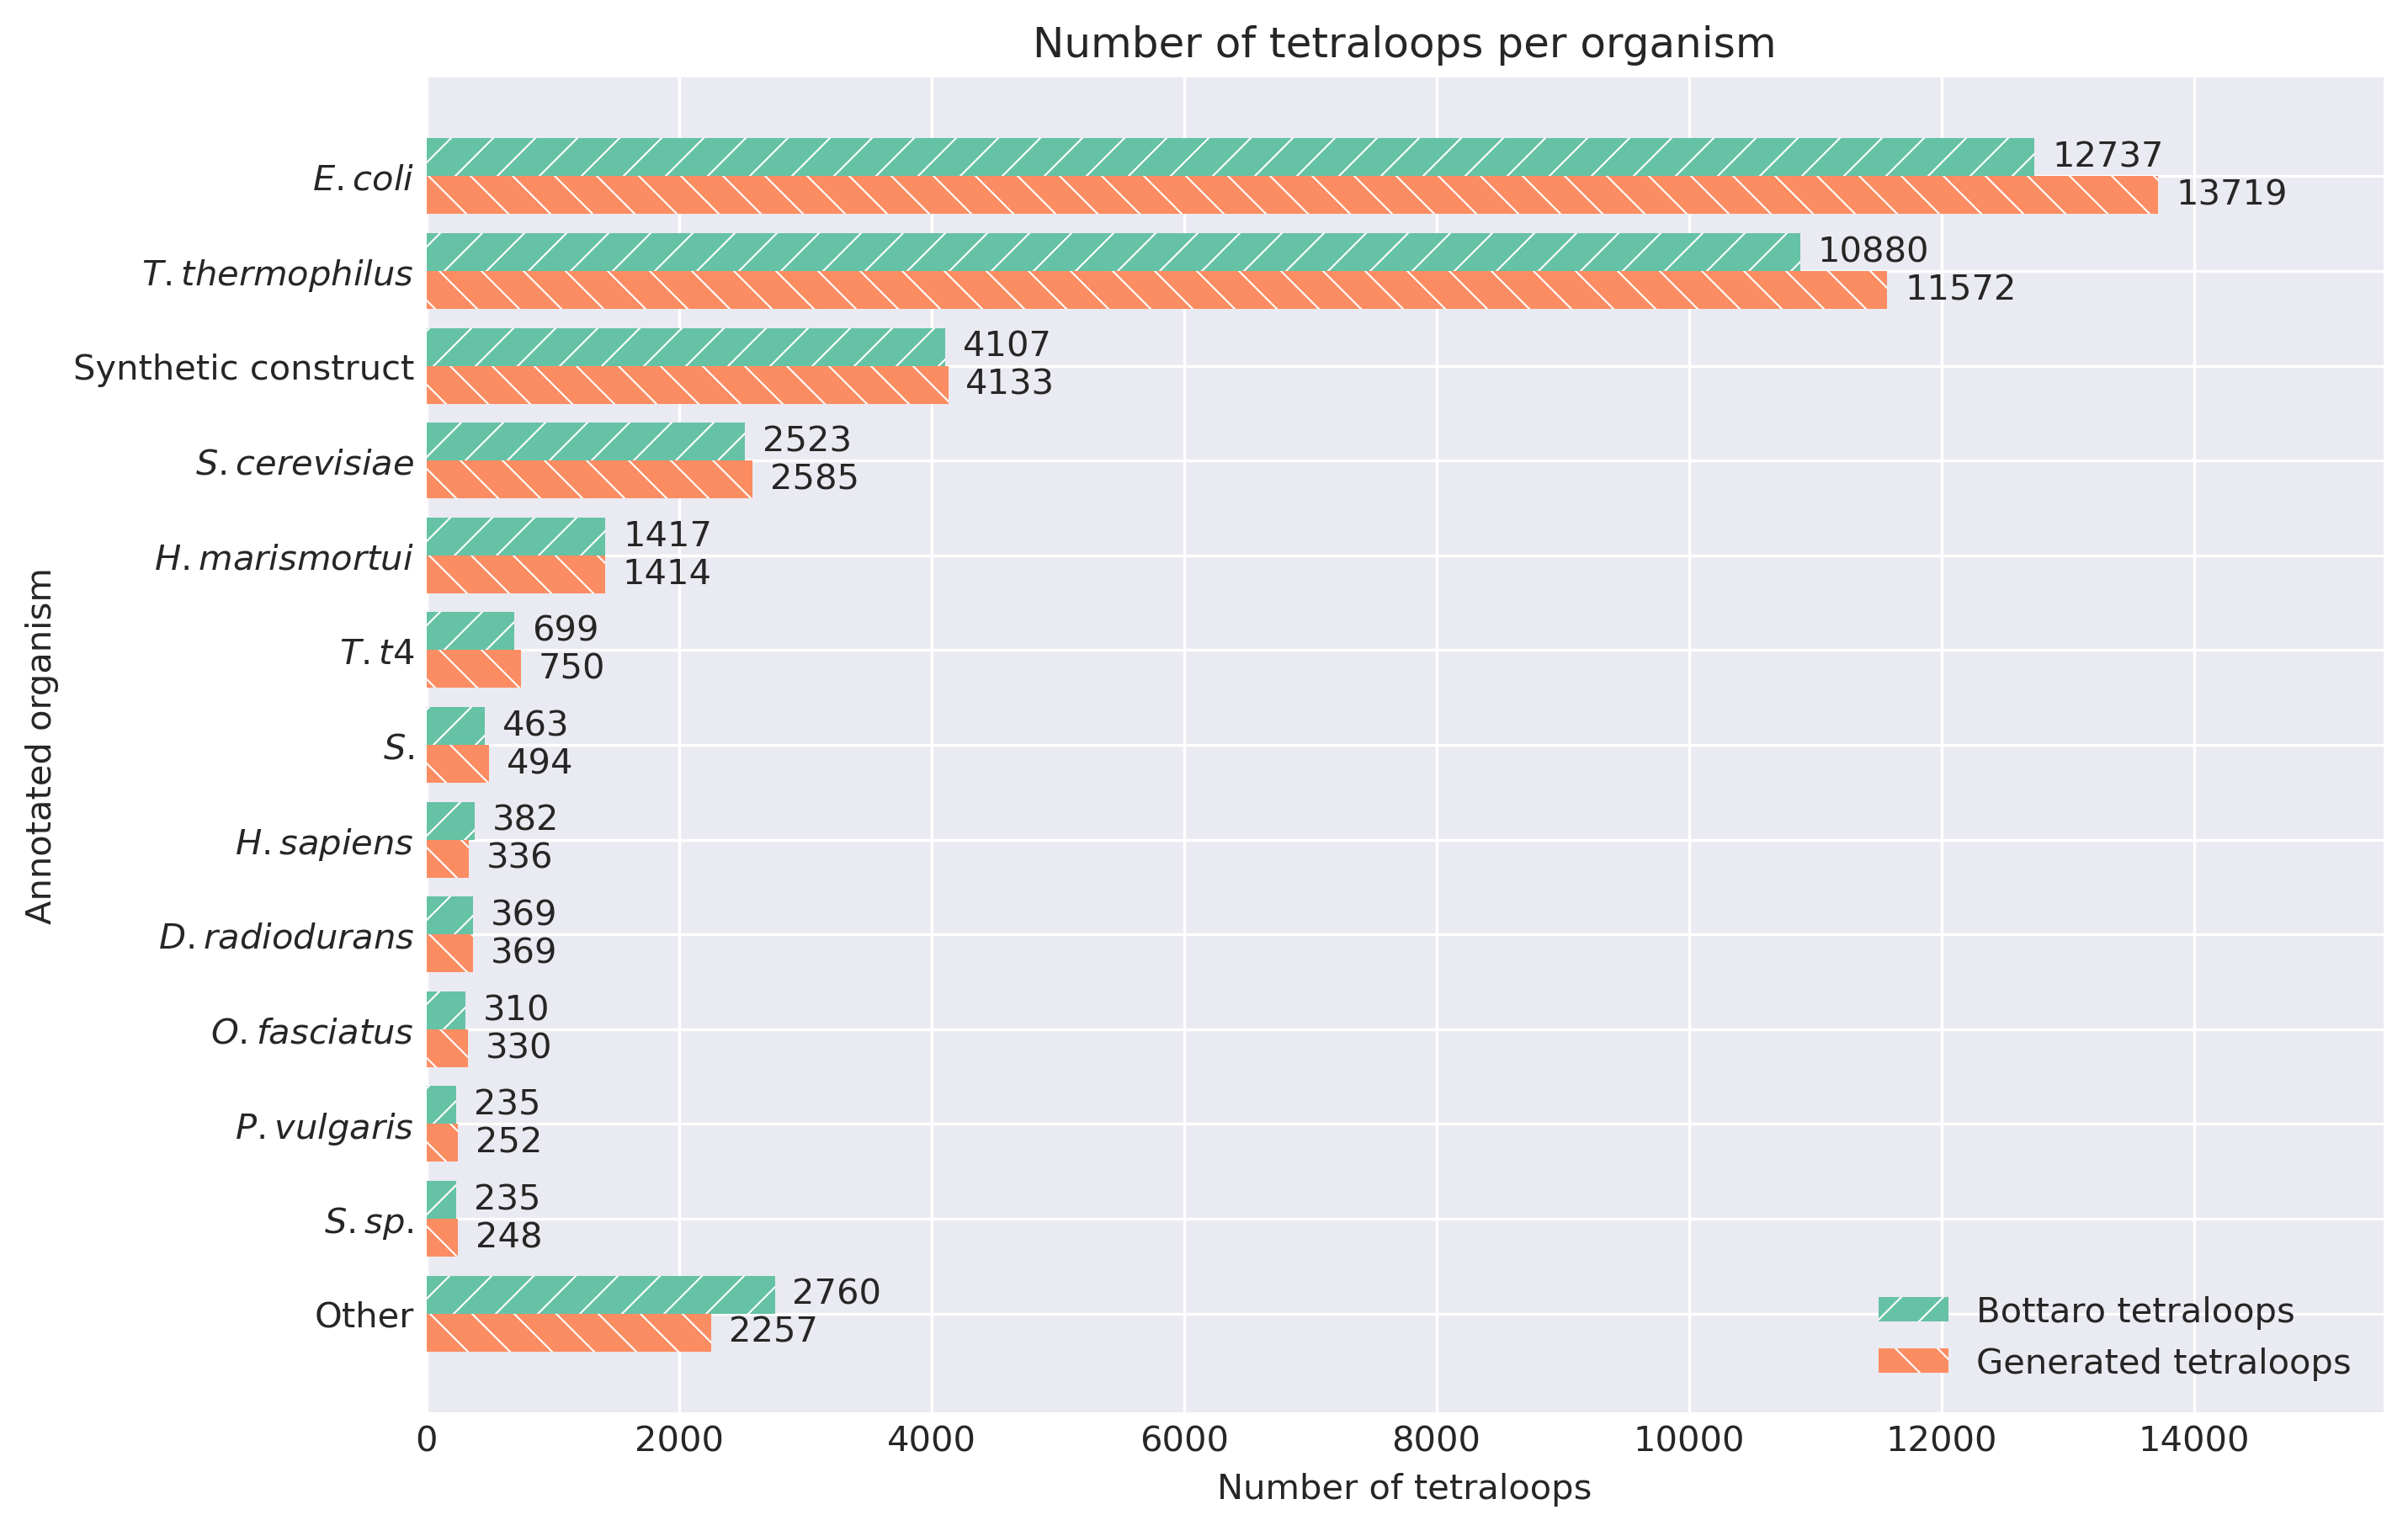

In [18]:
# Organisms

# Get organisms
bottaro_organisms = [j.lower() for i in get_pdb_ids(tloops) for j in get_organisms(i)]
generated_organisms = [j.lower() for i in get_pdb_ids(fragments_8, clusters=list(range(1,45))) for j in get_organisms(i)]

fig, ax = plt.subplots(figsize=(10, 7), dpi=300)
fig.subplots_adjust(wspace=0.3)
fig.tight_layout

bar_height = 0.4

# Organisms

ax.set_title("Number of tetraloops per organism")
ax.set_ylabel("Annotated organism")
ax.set_xlabel("Number of tetraloops")
ax.set_xlim([0, 15500])

other_limit = 200

# Bottaro
bottaro_data = get_counter_dict(bottaro_organisms)
bottaro_merged = {"T. thermophilus": 0, "E. coli": 0, "S. cerevisiae": 0, "Other": 0}
for organism, count in bottaro_data.items():
    if "thermus thermophilus" in organism:          bottaro_merged["T. thermophilus"] += count
    elif "escherichia coli" in organism:            bottaro_merged["E. coli"] += count
    elif "saccharomyces cerevisiae" in organism:    bottaro_merged["S. cerevisiae"] += count
    elif count < other_limit:                       bottaro_merged["Other"] += count
    else:
        generic = organism.capitalize().split()[0][0] + ". "
        species = " ".join(organism.split()[1:])
        name = generic + species if organism != "synthetic construct" else organism.capitalize()
        bottaro_merged[name] = count
bottaro_merged = dict(sorted(bottaro_merged.items(), key=lambda item: item[1]))
bottaro_merged = {'Other': bottaro_merged.pop('Other'), **bottaro_merged}

y_pos = np.arange(len(bottaro_merged))
bar = ax.barh(y_pos, bottaro_merged.values(), height=bar_height, align="edge", hatch=HATCHES[0])
ax.bar_label(bar, padding=5)
_ = ax.set_yticks(y_pos, labels=[f"$\it{'{'+i+'}'}$" if i not in ["Synthetic construct", "Other"] else i for i in bottaro_merged.keys()])

# Generated
generated_data = get_counter_dict(generated_organisms)
generated_merged = dict(zip(bottaro_merged.keys(), np.zeros(len(bottaro_merged))))
for organism, count in generated_data.items():
    if "thermus thermophilus" in organism:          generated_merged["T. thermophilus"] += count
    elif "escherichia coli" in organism:            generated_merged["E. coli"] += count
    elif "saccharomyces cerevisiae" in organism:    generated_merged["S. cerevisiae"] += count
    elif count < other_limit:                       generated_merged["Other"] += count
    else:
        generic = organism.capitalize().split()[0][0] + ". "
        species = " ".join(organism.split()[1:])
        name = generic + species if organism != "synthetic construct" else organism.capitalize()
        generated_merged[name] = count

bar = ax.barh(y_pos, generated_merged.values(), height=-bar_height, align="edge", hatch=HATCHES[1])
ax.bar_label(bar, padding=5)

ax.legend(labels=["Bottaro tetraloops", "Generated tetraloops"], loc="lower right")

fig.savefig(FIGURES_DIR/"organisms.png", bbox_inches='tight', dpi=300)

# NOTE conclusion: pretty much just proportionally reduce the amount of everything

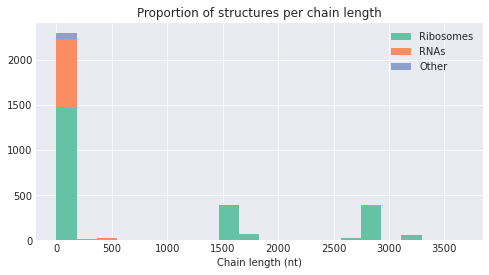

In [11]:
# Chain length vs. structure annotation

num_bins = 20

fig, ax = plt.subplots(figsize=(8,4))

ax.set_title("Proportion of structures per chain length")
ax.set_xlabel("Chain length (nt)")

chain_lengths = [len(i) for i in chains_annotated]
bin_lims = np.linspace(min(chain_lengths), max(chain_lengths), num=num_bins+1)
bin_size = bin_lims[1] - bin_lims[0]

chain_bins = [[] for i in range(num_bins)]
for chain in chains_annotated:
    bin_idx = int((len(chain))/bin_size)
    if bin_idx == num_bins: bin_idx -= 1
    chain_bins[bin_idx] += [chain]

size_counts = {"Ribosomes": np.zeros(num_bins), "RNAs": np.zeros(num_bins), "Other": np.zeros(num_bins)} 

for bin_idx, bin in enumerate(chain_bins):
    for chain in bin:
        structure = get_structure(chain.pdb_id).lower()
        if "ribosome" in structure: size_counts["Ribosomes"][bin_idx] += 1
        elif "rna" in structure:    size_counts["RNAs"][bin_idx] += 1 #? what does "RNA" mean? just "non-ribosomal"?
        else:                       size_counts["Other"][bin_idx] += 1

bottom = np.zeros(num_bins)
for boolean, size_count in size_counts.items():
    bars = ax.bar(bin_lims[:-1], size_count, width=bin_size, label=boolean, bottom=bottom, align='edge')
    # ax.bar_label(bars, [i if i > 30 else "" for i in size_count], padding=5)
    bottom += size_count

ax.legend(loc="upper right")
fig.savefig(FIGURES_DIR/"structure_proportions_v_chain_length.png", bbox_inches='tight')

#! bottaro says it's all ribosomes so these categories may be meaningless

# Mutual information

In [23]:
mi_fragments = [i for i in fragments_24 if i.clust_id != 0]

# homology reduction
unique_seqs = list(set([i.res_seq for i in mi_fragments]))

seq_len = len(unique_seqs[0])
flanking_idxs = range(0, int((seq_len - 4)/2))[::-1]
for idx, pos in enumerate(flanking_idxs):
    pos_opp = seq_len -1 - pos

    pos_seq = "".join([i[pos] for i in unique_seqs])
    pos_opp_seq = "".join([i[pos_opp] for i in unique_seqs])
    all_seq = pos_seq + pos_opp_seq

    for x, y in combinations(['A', 'U', 'C', 'G'], 2):
        P_X1 = pos_seq.count(x)/len(pos_seq)
        P_X2 = pos_opp_seq.count(x)/len(pos_opp_seq)
        P_Y1 = pos_seq.count(y)/len(pos_seq)
        P_Y2 = pos_opp_seq.count(y)/len(pos_opp_seq)
        P_XY = list(zip(pos_seq, pos_opp_seq)).count((x, y))/len(pos_seq)
        P_YX = list(zip(pos_seq, pos_opp_seq)).count((y, x))/len(pos_seq)
        
        P1 = P_XY*log(P_XY/(P_X1*P_Y2), 2) if P_XY else 0
        P2 = P_YX*log(P_YX/(P_Y1*P_X2), 2) if P_YX else 0

        I = P1 + P2
    print(f"Pair {idx+1} ({x}, {y}): {I:>5.2f}")

Pair 1 (A, U):  0.48
Pair 1 (A, C): -0.02
Pair 1 (A, G):  0.01
Pair 1 (U, C): -0.02
Pair 1 (U, G): -0.05
Pair 1 (C, G):  0.72
Pair 2 (A, U):  0.58
Pair 2 (A, C): -0.02
Pair 2 (A, G): -0.03
Pair 2 (U, C):  0.00
Pair 2 (U, G): -0.06
Pair 2 (C, G):  0.87
Pair 3 (A, U):  0.39
Pair 3 (A, C): -0.05
Pair 3 (A, G):  0.01
Pair 3 (U, C): -0.04
Pair 3 (U, G): -0.04
Pair 3 (C, G):  0.65
Pair 4 (A, U):  0.24
Pair 4 (A, C): -0.04
Pair 4 (A, G): -0.06
Pair 4 (U, C): -0.06
Pair 4 (U, G): -0.01
Pair 4 (C, G):  0.37
Pair 5 (A, U):  0.11
Pair 5 (A, C): -0.03
Pair 5 (A, G): -0.02
Pair 5 (U, C): -0.03
Pair 5 (U, G): -0.03
Pair 5 (C, G):  0.21
Pair 6 (A, U):  0.04
Pair 6 (A, C): -0.01
Pair 6 (A, G): -0.02
Pair 6 (U, C): -0.03
Pair 6 (U, G): -0.00
Pair 6 (C, G):  0.06
Pair 7 (A, U):  0.05
Pair 7 (A, C):  0.08
Pair 7 (A, G): -0.03
Pair 7 (U, C): -0.05
Pair 7 (U, G):  0.08
Pair 7 (C, G):  0.10
Pair 8 (A, U):  0.02
Pair 8 (A, C): -0.01
Pair 8 (A, G):  0.01
Pair 8 (U, C): -0.04
Pair 8 (U, G):  0.04
Pair 8 (C, G)

# Tetraloops
> The final tetraloop database is composed by 21,993 RNA fragments: 17,709 from X-ray, 3057 from NMR and 1227 from cryo-EM structures. The distributions of resolutions are shown in Fig. S1. [Bottaro et al.](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5529312/)

According to Table SI1, there should be a total of 19383 tetraloops. I don't know where/what the remaining 2610 RNA fragments (from the total of 21993) are. The total number of "effective" tetraloops (members whose distance is above 0.07 eRMSD) is 16979.

In [39]:
# Unique sequences

generated_tloops = [i for i in fragments_8 if i.clust_id in range(1,45)]

print(f"Set        | {              'Total':<5} | {                          'Unique sequences':<16} | PDB IDs")
print(f"Bottaro    | {          len(tloops):<5} | {          len(get_seqs(tloops, unique=True)):<16} | {len(get_pdb_ids(tloops, unique=True))}")
print(f"Generated  | {len(generated_tloops):<5} | {len(get_seqs(generated_tloops, unique=True)):<16} | {len(get_pdb_ids(generated_tloops, unique=True))}")
# print(f"Bottaro (filtered)  {len(tloops_filtered):<7}{len(get_seqs(tloops_filtered, unique=True)):<18}{len(get_pdb_ids(tloops_filtered, unique=True))}")

Set        | Total | Unique sequences | PDB IDs
Bottaro    | 19383 | 292              | 864
Generated  | 18561 | 292              | 864


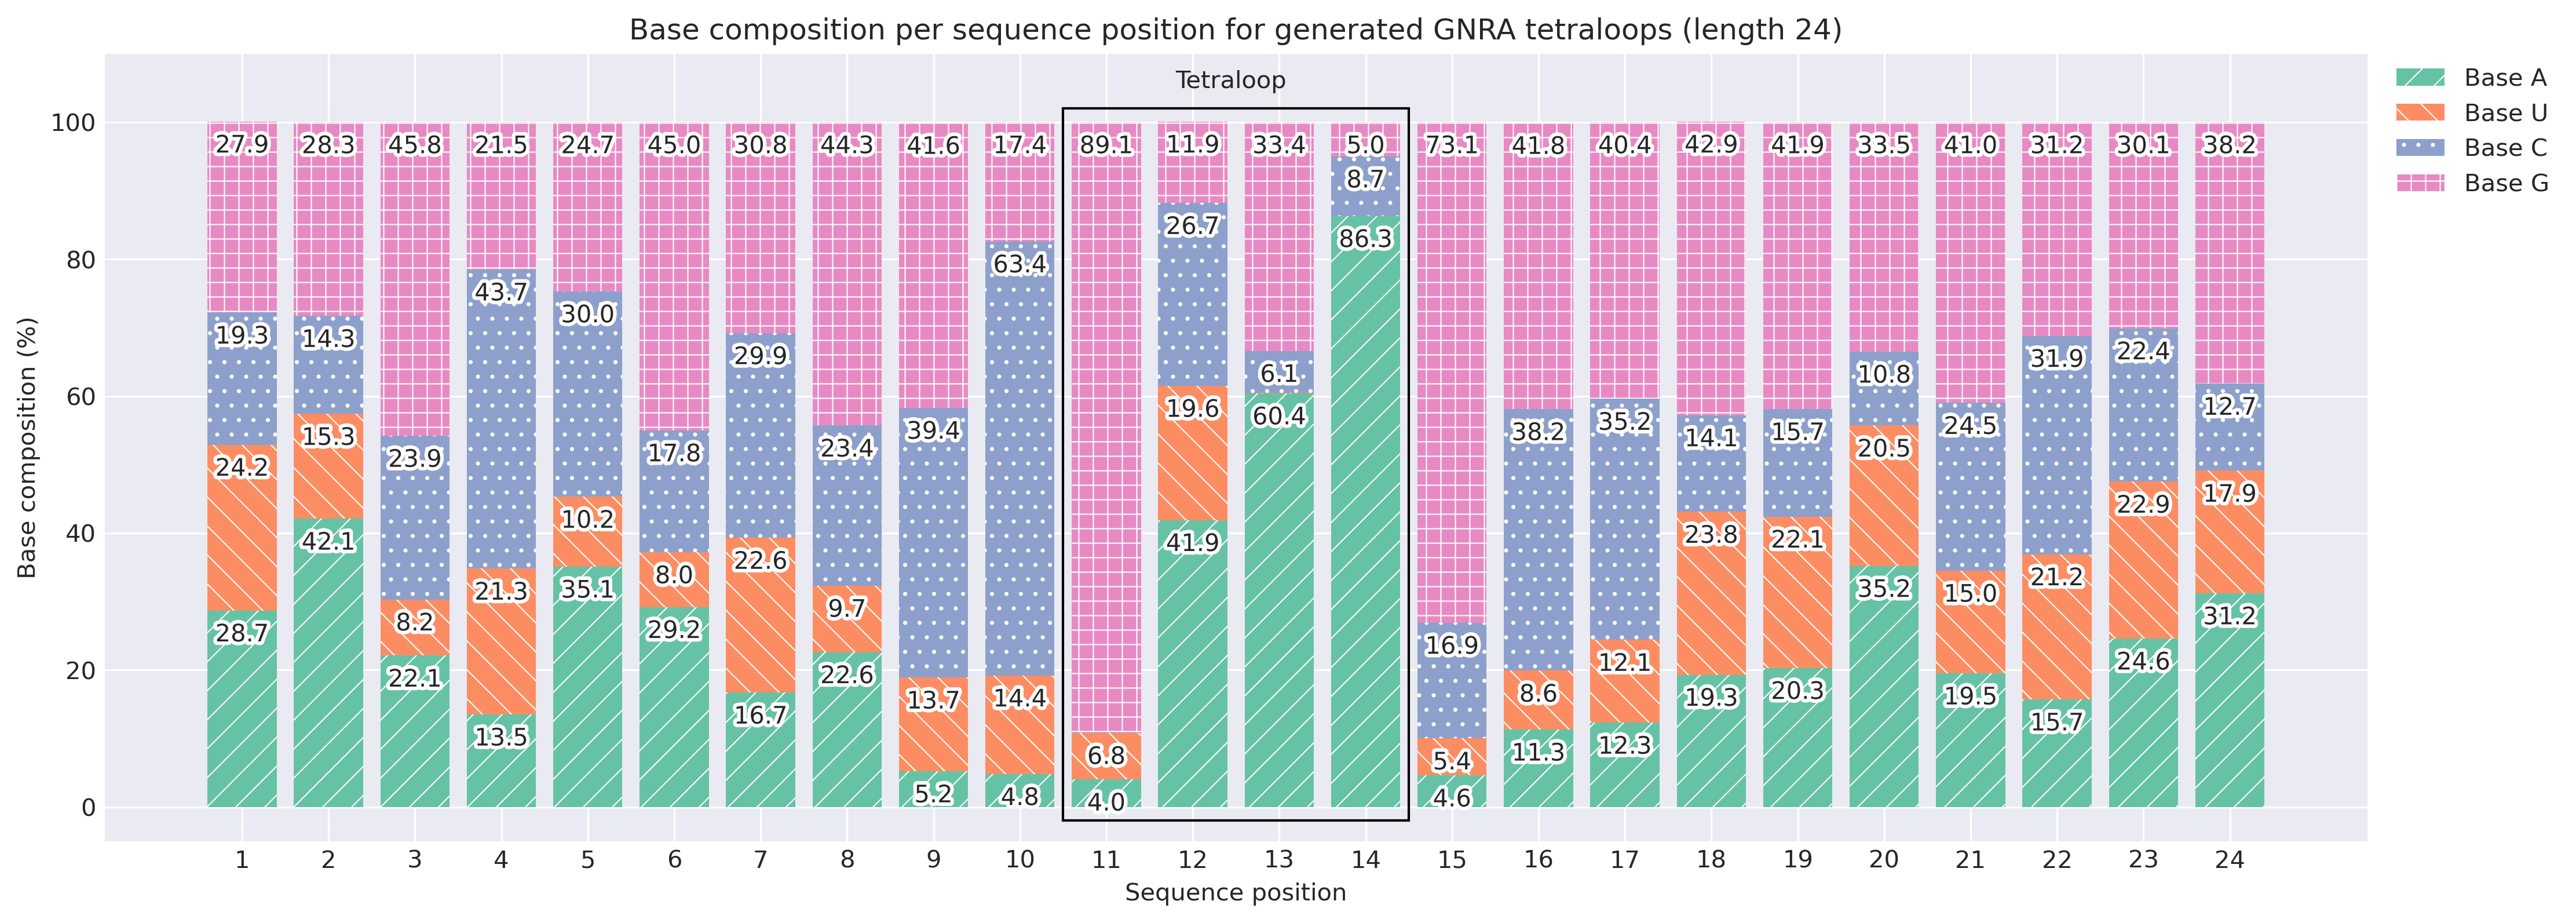

In [41]:
# Residue position histogram

tloops = [i for i in fragments_24 if i.clust_id == 1] #!

sequences = get_seqs(tloops)
res_names = ['A','U','C','G'] # N, I
sequence_length = len(sequences[0])
res_array = np.zeros(shape=(len(res_names), sequence_length))
for seq in sequences:
    for pos, res in enumerate(seq):
        res_array[res_names.index(res)][pos] += 1
res_array = res_array/res_array.sum(axis=0, keepdims=True)

fig, ax = plt.subplots(figsize=(sequence_length*0.7,6), dpi=300)
ax.set_title(f"Base composition per sequence position for generated GNRA tetraloops (length {sequence_length})") #!
ax.set_xlabel("Sequence position")
ax.set_ylabel("Base composition (%)")
ax.set_ylim([-5, 110])

positions = range(1, sequence_length+1)
ax.set_xticks(positions)

bottom = np.zeros(sequence_length)
for index, percentages in enumerate(res_array):
    percentages = [round(i*100, 1) for i in percentages]
    bar = ax.bar(positions, percentages, bottom=bottom, label=f"Base {res_names[index]}", hatch = HATCHES[index])
    txts = ax.bar_label(bar, [i if i >= 1 else "" for i in percentages], padding=-15)
    for txt in txts: txt.set_path_effects([PathEffects.withStroke(linewidth=3, foreground='w')])
    bottom += percentages

# Highlight box
rect = patches.Rectangle((10.5, -2), 4, 104, linewidth=1, edgecolor='black', facecolor='none')
ax.add_patch(rect)
ax.text(11.8,105,"Tetraloop")

ax.grid(which='minor')

ax.legend(loc='upper right', bbox_to_anchor=(1.09,1.01))
fig.savefig(FIGURES_DIR/"residue_composition.png", bbox_inches='tight', dpi=300)

#! imbalance further than in just the tetraloop itself, also found in the flanking regions
# TODO generate this for GNRA as well

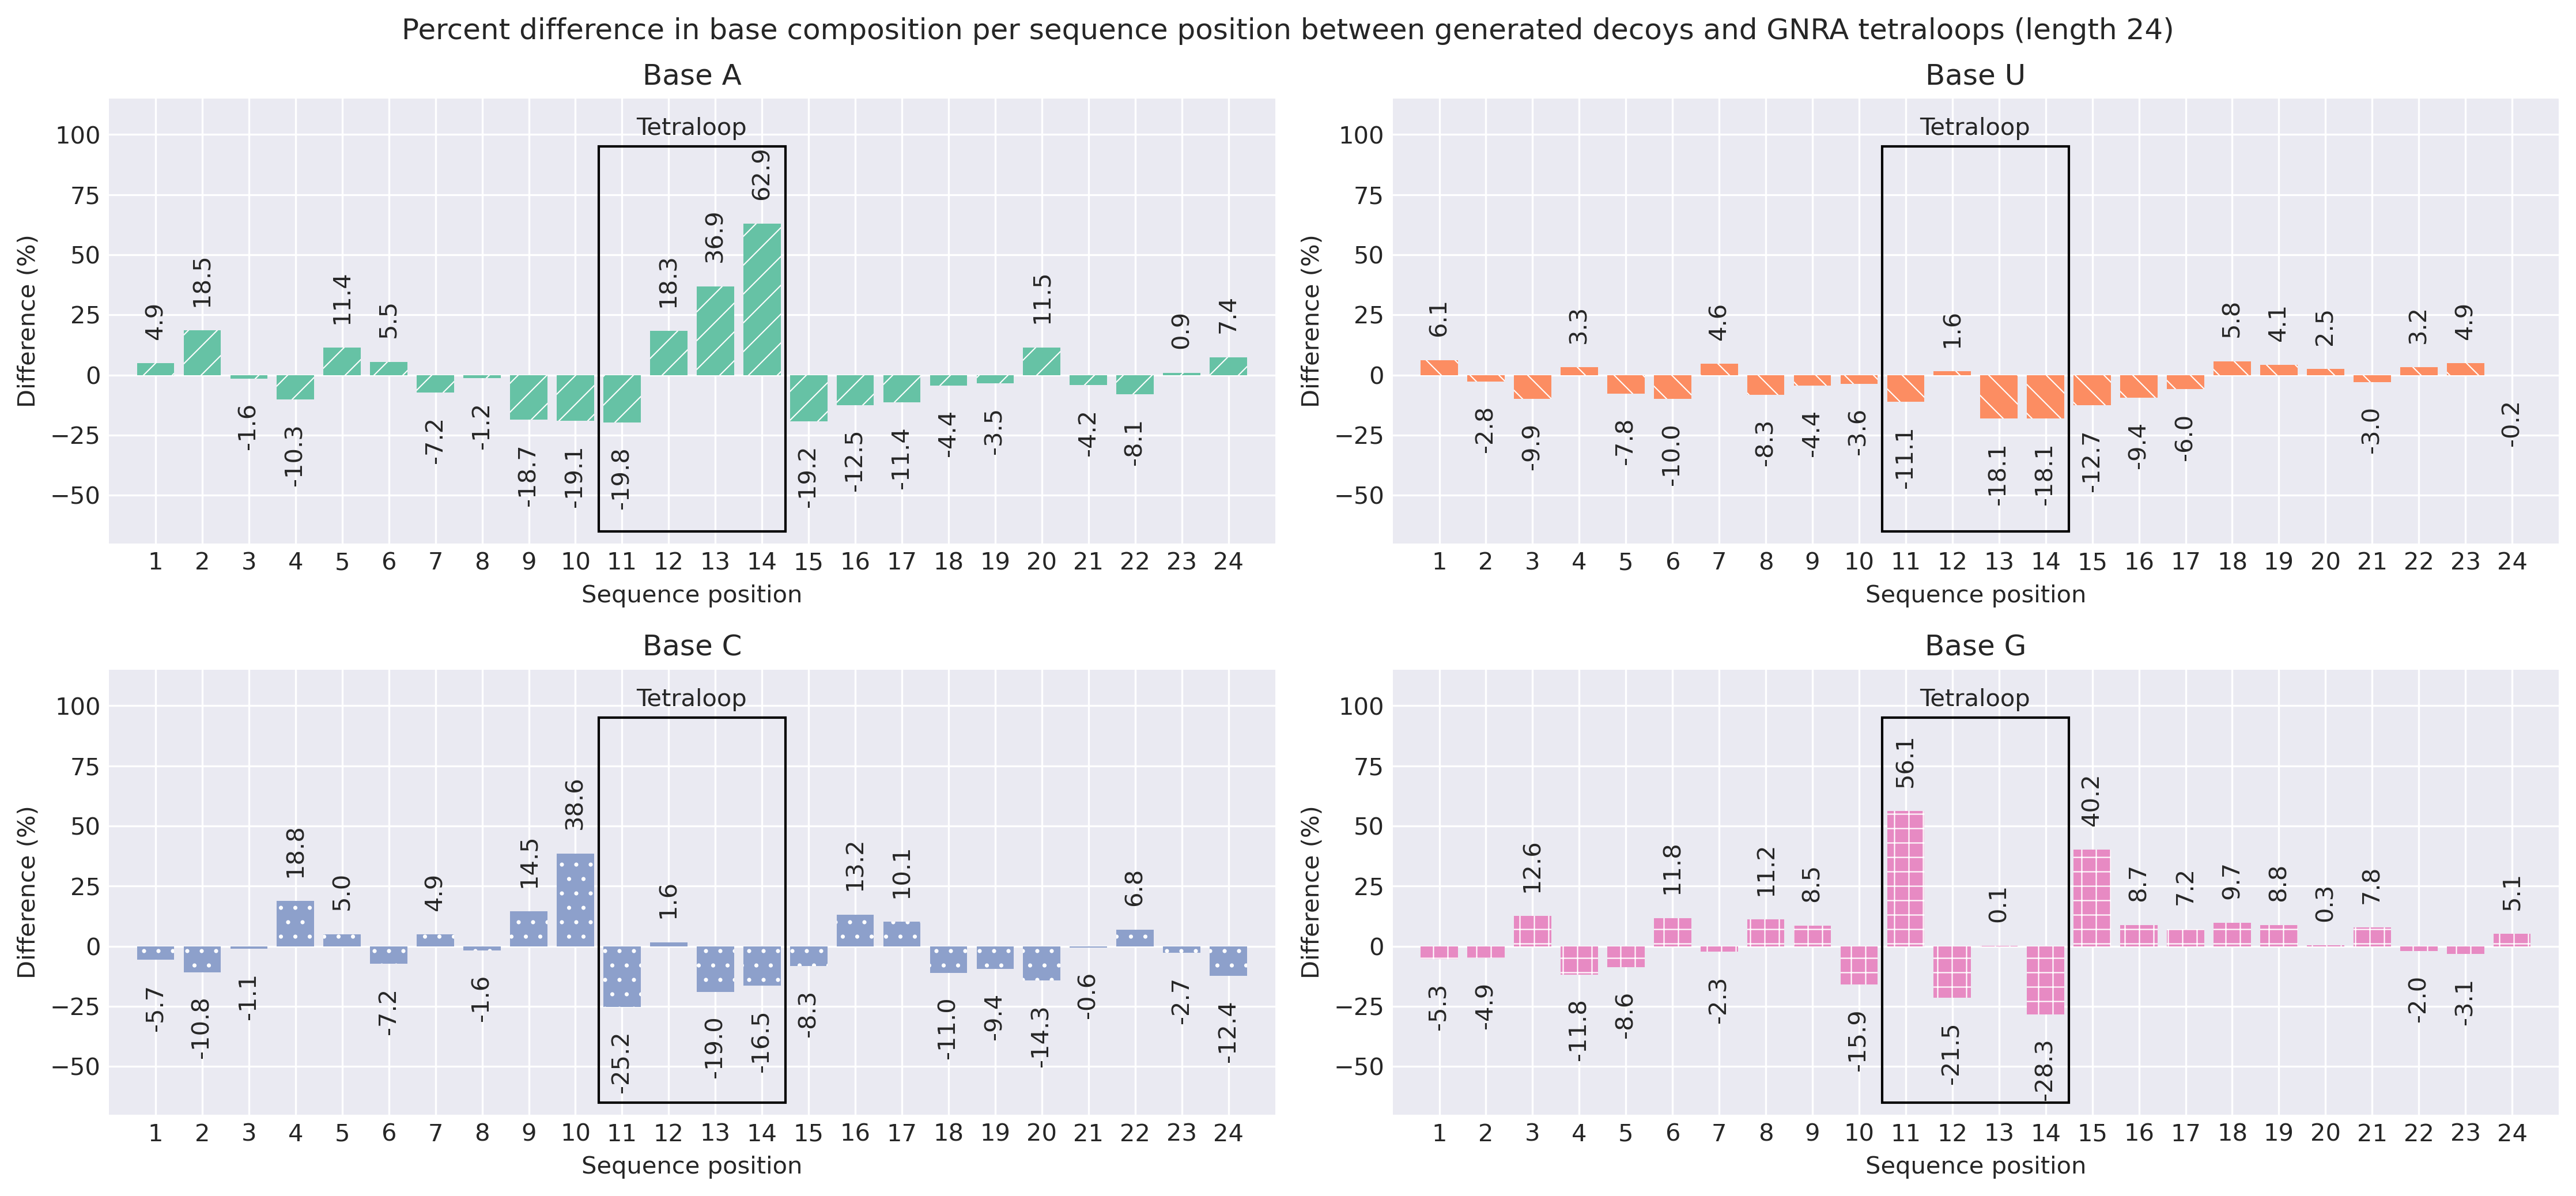

In [46]:
# Dataset residues
# TODO total amount of residues in entire dataset. compare to overall abundance in dataset (number of Us, etc.?)
# are the residue distributions independent or dependent? 
# is the residue composition at each position (outside of the core tetraloop) independent or dependent of the cluster identity

res_names = ['A','U','C','G','I','N'] # N
seq_length = 24

res_dict = dict(zip(res_names, [0]*len(res_names)))
empty_res_per_pos = dict(zip(range(seq_length), list((res_dict.copy() for i in range(seq_length)))))

#  Base percentages

base_res_per_pos = deepcopy(empty_res_per_pos)
base_seqs = get_seqs(fragments_24, clusters=[0]) #!

for seq in base_seqs:
    for pos, res in enumerate(seq):
        base_res_per_pos[pos][res] += 1

for pos, pos_dict in base_res_per_pos.items():
    for res, count in pos_dict.items():
        base_res_per_pos[pos][res] = count/len(base_seqs)

# Target percentages

target_res_per_pos = deepcopy(empty_res_per_pos)
target_seqs = get_seqs(fragments_24, clusters=[1]) #!

for seq in target_seqs:
    for pos, res in enumerate(seq):
        target_res_per_pos[pos][res] += 1

for pos, pos_dict in target_res_per_pos.items():
    for res, count in pos_dict.items():
        target_res_per_pos[pos][res] = count/len(target_seqs)

# Difference

diffs_res_per_pos = deepcopy(empty_res_per_pos)

for pos, pos_dict in diffs_res_per_pos.items():
    for res in pos_dict:
        diffs_res_per_pos[pos][res] = (target_res_per_pos[pos][res]-base_res_per_pos[pos][res])*100

# Data

data_dict = dict(zip(res_names, list([[] for i in range(seq_length)])))

for res in res_names:
    for pos in range(seq_length):
        data_dict[res] += [diffs_res_per_pos[pos][res]]

# Plotting

positions = range(1,seq_length+1)
fig, axes = plt.subplots(3, 2, figsize=(15, 10), dpi=300)
fig.suptitle(f"Percent difference in base composition per sequence position between generated decoys and GNRA tetraloops (length {seq_length})")

for idx, res in enumerate(res_names):
    ax = axes[idx//2, idx%2]
    ax.set_ylabel("Difference (%)")
    ax.set_xlabel("Sequence position")
    ax.set_xticks(positions)
    ax.set_xlim([0,25]); ax.set_ylim([-70,115])
    ax.set_title(f"Base {res}")
    bar = ax.bar(positions, data_dict[res], color=COLORS[idx], hatch=HATCHES[idx])
    ax.bar_label(bar, [round(i, 1) for i in data_dict[res]], rotation="vertical", padding=10)

    # Highlight box
    rect = patches.Rectangle((10.5, -65), 4, 160, linewidth=1, edgecolor='black', facecolor='none')
    ax.add_patch(rect)
    ax.text(11.3,100,"Tetraloop")


axes[2,0].remove(); axes[2,1].remove()
fig.tight_layout()

ax.grid(which='minor')

fig.savefig(FIGURES_DIR/"residue_composition_percentage.png", bbox_inches='tight', dpi=300)

In [68]:
# Missing Tetraloop sequences (found in Bottaro but not in Generated)

tloop_seqs = set([i.res_seq for i in tloops])
tloop_fragment_seqs = set([i.res_seq for i in fragments_8 if i.clust_id != 0])

missing_seqs = tloop_seqs - tloop_fragment_seqs
print(f"Sequences missing from Fragments: {missing_seqs}")
missing_tloops = [i for i in tloops if i.res_seq in missing_seqs]
print(f"{len(missing_tloops)} tetraloops missing from Fragments")

if missing_tloops:
    print(f"{  'Cluster ID':<10} | {'PDB ID':<6} | {  'Sequence'} | {'Residue number'}")
    for i in missing_tloops:
        print(f"{i.clust_id:<10} | {i.pdb_id:<6} | {i.res_seq:<8} | {i.res_nums[0]}")

Sequences missing from Fragments: set()
0 tetraloops missing from Fragments


# Chains

In [71]:
print(f"{                 'Total'} | {                              'Unique sequences'} | {'PDB IDs'}")
print(f"{len(chains_annotated):<5} | {len(get_seqs(chains_annotated, unique=True)):<16} | {len(get_pdb_ids(chains_annotated, unique=True))}")
# print(f"Filtered | {len(chains_annotated_filtered):<7}{len(get_seqs(chains_annotated_filtered, unique=True)):<18}{len(get_pdb_ids(chains_annotated_filtered, unique=True))}")

Total | Unique sequences | PDB IDs
3284  | 1032             | 864


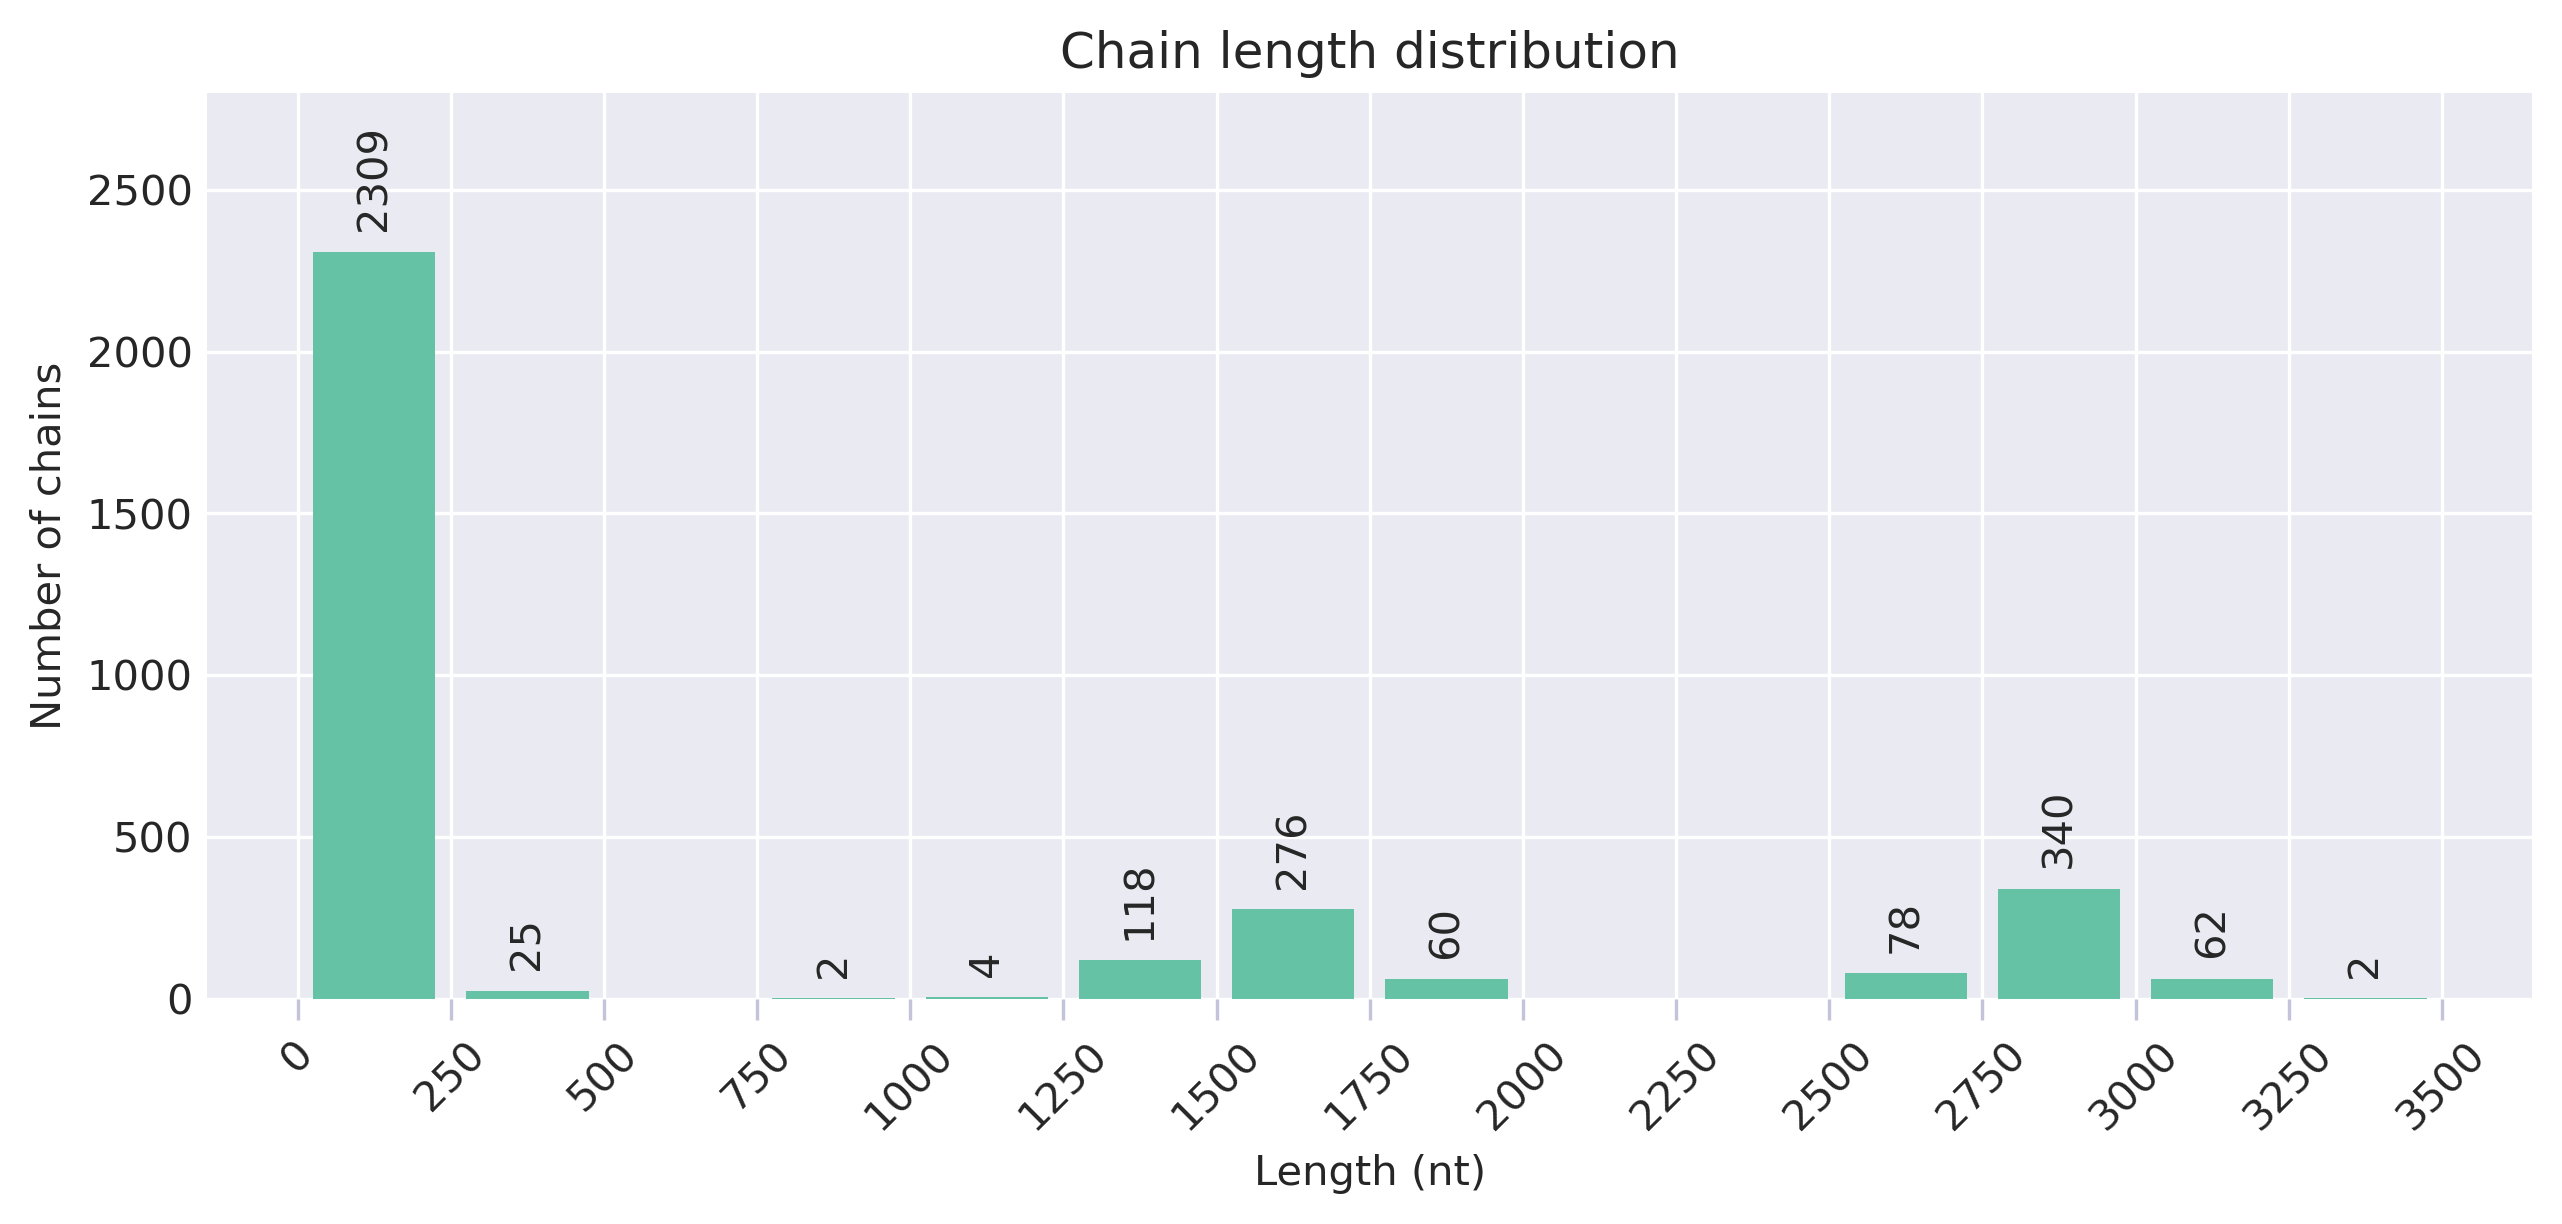

In [79]:
# Chain length distribution

fig, ax = plt.subplots(figsize=(10, 4), dpi=300)

ax.set_title("Chain length distribution")
ax.set_xlabel("Length (nt)")
ax.set_ylabel("Number of chains")
ax.set_ylim([0, 2800])

#// data = [[len(i) for i in chains_annotated_raw], [len(i) for i in chains_annotated_filtered]]
#// values, _, bars = ax.hist(data, bins = range(0, max(data[0]), 250), label=["Raw chains", "Filtered chains"], rwidth=0.8)
#// for patch_set, hatch in zip(bars, hatches): plt.setp(patch_set, hatch=hatch)
#// ax.bar_label(bars[0], labels=[int(i) if i != 0 else "" for i in values[0]], rotation='vertical', padding=5)
#// ax.bar_label(bars[1], labels=[int(i) if i != 0 else "" for i in values[1]], rotation='vertical', padding=5)
#// ax.set_xticks(range(0, max(data[0]), 250))
#// ax.tick_params(axis='x', rotation=45, length=5, color="#C3C3DA")
#// ax.legend()

data = [len(i) for i in chains_annotated]
values, _, bars = ax.hist(data, bins = range(0, max(data), 250), rwidth=0.8)
ax.bar_label(bars, labels=[int(i) if i != 0 else "" for i in values], rotation='vertical', padding=5)
ax.set_xticks(range(0, max(data), 250))
ax.tick_params(axis='x', rotation=45, length=5, color="#C3C3DA")

fig.savefig(FIGURES_DIR/"chain_lengths.png", bbox_inches='tight', dpi=300)

# TODO labels (16s, 23, what's the peak at 100 for)? ensure binning is correct

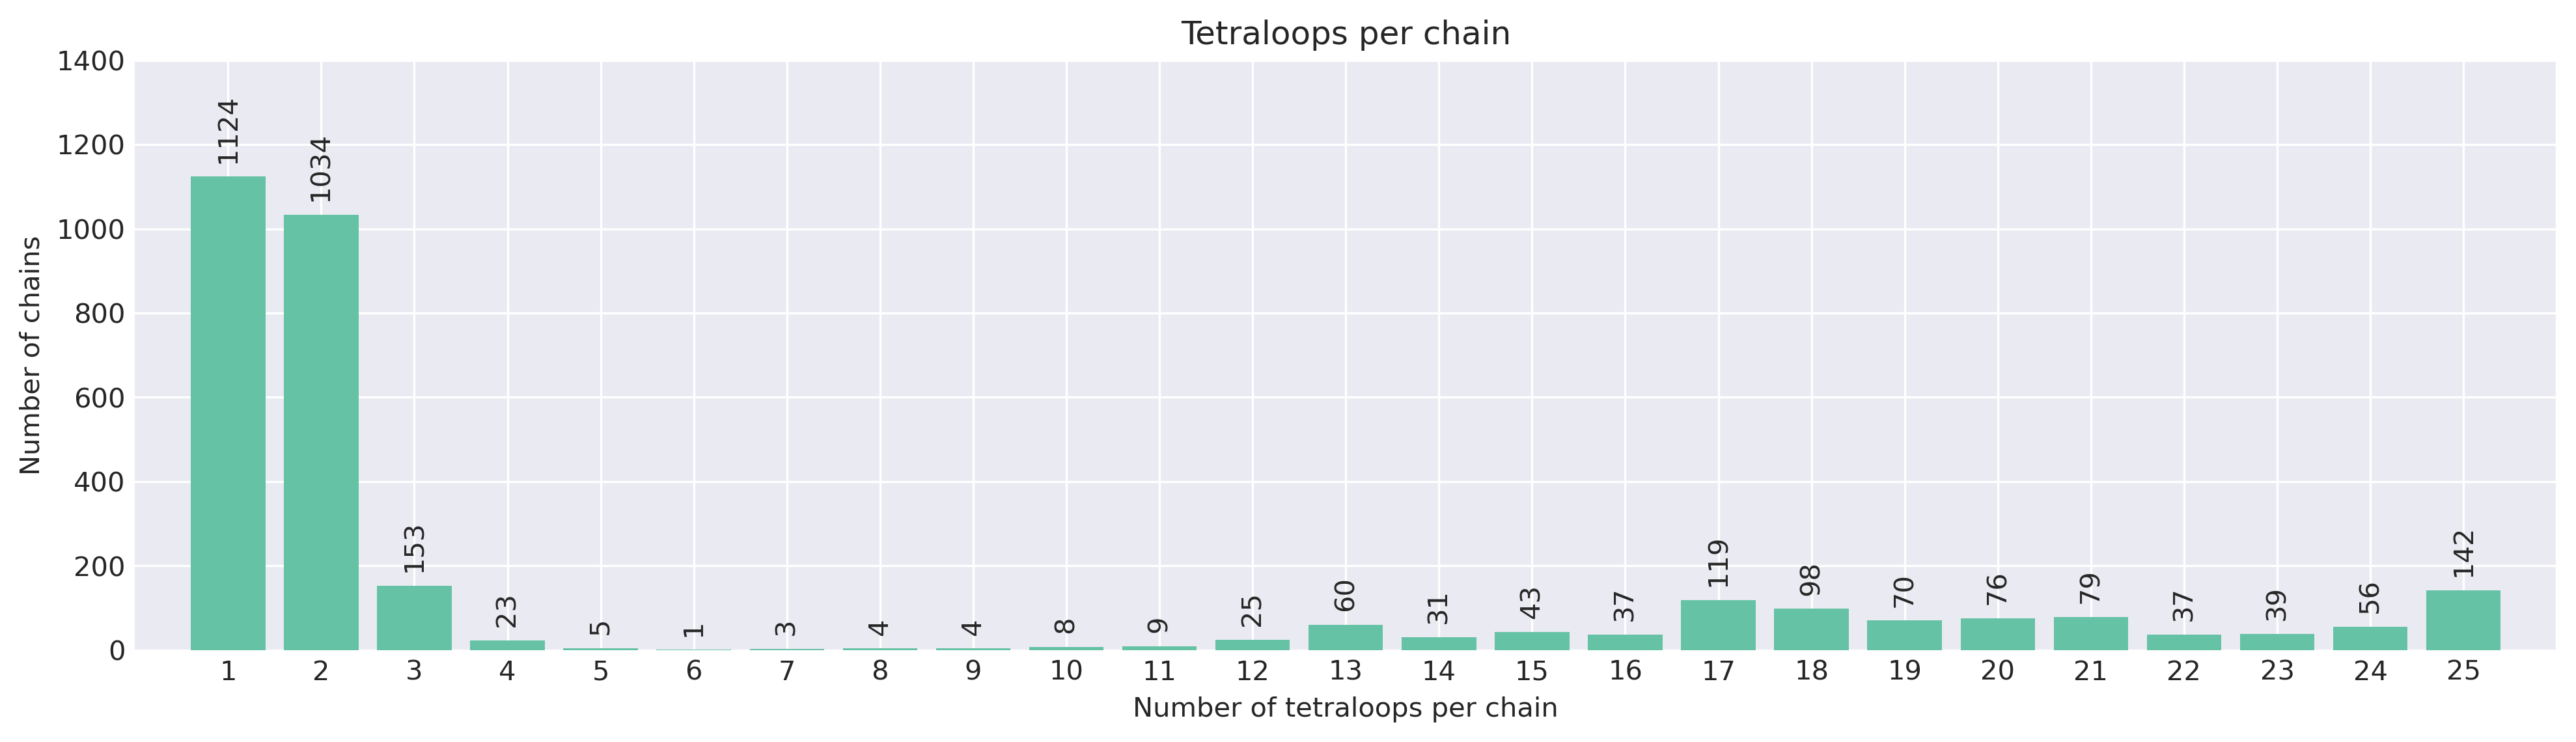

In [82]:
# Number of tetraloops per annotated chain
# check the chains with the highest number of tetraloops

fig, ax = plt.subplots(figsize=(16, 4), dpi=300)

ax.set_title("Tetraloops per chain")
ax.set_xlabel("Number of tetraloops per chain")
ax.set_ylabel("Number of chains")
ax.set_ylim([0, 1400])
ax.set_xlim([-1,25])

#// data = [[len(i.tloops) for i in chains_annotated_raw], [len(i.tloops) for i in chains_annotated_filtered]
#// values, _, bars = ax.hist(data, bins = range(0, max(data[0])), label=["Raw chains", "Filtered chains"], rwidth=0.8, align="left", hatch=[hatches[0], hatches[1]])
#// for patch_set, hatch in zip(bars, hatches): plt.setp(patch_set, hatch=hatch)
#// ax.bar_label(bars[0], labels=[int(i) if i != 0 else "" for i in values[0]], rotation='vertical', padding=5)
#// ax.bar_label(bars[1], labels=[int(i) if i != 0 else "" for i in values[1]], rotation='vertical', padding=5)
#// ax.set_xticks(range(0, max(data[0])))
#// ax.set_xticklabels(list(range(1, max(data[0]))) + [""])
#// ax.grid(which="minor")
#// ax.legend()

data = [len(i.tloops) for i in chains_annotated]

values, _, bars = ax.hist(data, bins = range(0, max(data)), rwidth=0.8, align="left")
ax.bar_label(bars, labels=[int(i) if i != 0 else "" for i in values], rotation='vertical', padding=5)
ax.set_xticks(range(0, max(data)))
ax.set_xticklabels(list(range(1, max(data))) + [""])
ax.grid(which="minor")

fig.savefig(FIGURES_DIR/"tloops_per_chain.png", bbox_inches='tight', dpi=300)

# TODO this figure represents the diversity in number of tetraloops per chain. much more variable than expected? don't go to deep into this. annotate range with 23s 16s etc.?

# Fragments

## Unique sequences

For a sequence of length 8, the number of unique RNA sequences is $4^{8} = 65536$ (or $6^{8} = 1679616$, if residues I and N are included). 

Expected number of tries to obtain $x$ unique sequences:
$$\sum\limits_{i=0}^x \frac{n}{n-i}$$
where $n$ = total number of unique sequences

The expected number of tries needed to obtain *all* unique sequences of length 8 is $764646$.

In [87]:
# Possible number of unique fragments (assuming each residue is independent) vs. actual number of unique fragments (and expected number of tries to obtain said number)

print(f"{      'Length'} | {   'Total':<7} | {   'Possible':<15} | {          'Expected unique':<15} | {'Actual unique'}")
for seq_len, frags in zip(range(8,25,2), fragments):
    possible_seqs = 4**seq_len
    actual_unique_seqs = len(get_seqs(frags, unique=True))
    #// expected_tries = sum([possible_seqs/(possible_seqs-i) for i in range(actual_unique_seqs)])
    expected_unique_seqs = possible_seqs*(1-(1-(1/possible_seqs))**len(frags))
    print(f"{seq_len:<6} | {len(frags):<7} | {possible_seqs:<15} | {round(expected_unique_seqs):<15} | {actual_unique_seqs}") #// {round(expected_tries_all)}

Length | Total   | Possible        | Expected unique | Actual unique
8      | 2261572 | 65536           | 65536           | 37227
10     | 2255426 | 1048576         | 926549          | 61741
12     | 2249379 | 16777216        | 2105107         | 67228
14     | 2243467 | 268435456       | 2234118         | 69749
16     | 2237707 | 4294967296      | 2237124         | 71590
18     | 2232051 | 68719476736     | 2232015         | 73110
20     | 2226732 | 1099511627776   | 2226730         | 74394


22     | 2221484 | 17592186044416  | 2221484         | 75528
24     | 2216289 | 281474976710656 | 2216289         | 76565


In [92]:
# Decoy sizes

decoys = [len([j for j in i if j.clust_id == 0]) for i in fragments]
print("Cluster | " + " | ".join([f"{i:<7}" for i in range(8, 25, 2)]))
print("Decoys  | " + " | ".join([f"{i:<7}" for i in decoys]))
# filtered_decoys = [len([j for j in i if j.clust_id == 0]) for i in fragments_filtered]

Cluster | 8       | 10      | 12      | 14      | 16      | 18      | 20      | 22      | 24     
Decoys  | 2243011 | 2236865 | 2230826 | 2224937 | 2219201 | 2213683 | 2208392 | 2203161 | 2197993


In [30]:
# Check which decoy sequences also appear as tloops

fragments_set = fragments_8

tloop_seqs = get_seqs([i for i in fragments_set if i.clust_id != 0], unique=True)
decoy_seqs = get_seqs([i for i in fragments_set if i.clust_id == 0], unique=True)
common_seqs = tloop_seqs.intersection(decoy_seqs)

tloop_frags = len([i for i in fragments_set if i.clust_id != 0])
decoy_frags = len([i for i in fragments_set if i.clust_id == 0])
common_tloop_frags = len([i for i in fragments_set if i.res_seq in common_seqs and i.clust_id != 0])
common_decoy_frags = len([i for i in fragments_set if i.res_seq in common_seqs and i.clust_id == 0])

print("Sequences")
print(f"{       'Tetraloop'} | {           'Decoy':<5} | {'Common'}")
print(f"{len(tloop_seqs):<9} | {   len(decoy_seqs):<5} | {len(common_seqs)}\n")
print("Fragments")
print(f"{   'Set':<9} | {          'Tetraloop'} | {           'Decoy':<8} | {'Total'}")
print(f"{   'All':<9} | {       tloop_frags:<9} | {       decoy_frags:<8} | {tloop_frags + decoy_frags}")
print(f"{'Common':<9} | {common_tloop_frags:<9} | {common_decoy_frags:<8} | {common_tloop_frags + common_decoy_frags}")
print(f"\n{'':=<45}\n")

# # Print all fragments
# for seq in common_seqs:
#     common_tloop_frags = [i for i in fragments_8 if i.res_seq == seq and i.clust_id != 0]
#     common_decoy_frags = [i for i in fragments_8 if i.res_seq == seq and i.clust_id == 0]
#     print(f"{seq}\n")
    
#     print(f"{               'Tetraloops'} | {'Fragments'}")
#     print(f"{len(common_tloop_frags):<10} | {len(common_decoy_frags)}\n")

#     print(f"{         'Cluster ID'} | {      'PDB ID'} | {      'Chain ID'} | {'Residue number'}")
#     for frag in common_tloop_frags + common_decoy_frags:
#         print(f"{frag.clust_id:<10} | {frag.pdb_id:<6} | {frag.chain_id:<8} | {frag.res_nums[0]}")
#     print(f"\n{'':=<45}\n")

Sequences
Tetraloop | Decoy | Common
292       | 37179 | 244

Fragments
Set       | Tetraloop | Decoy    | Total
All       | 18561     | 2243011  | 2261572
Common    | 18167     | 14021    | 32188




## Clusters

In [55]:
# Folds, as named in Bottaro et al. Table SI1

folds = {1: "GNRA", 3: "GNRA-like", 6: "GNRA-like", 9: "GNRA-like", 25: "GNRA-like", 26: "GNRA-like", 36: "GNRA-like", 40: "GNRA-like", 2: "UNCG", 5: "UNCG-like", 37: "UNCG-like", 44: "UNCG-like", 4: "U-TURN", 7: "7", 8: "8", 10: "10", 11: "4-Stack", 12: "12", 34: "34", 13: "13", 20: "20", 14: "14", 19: "19", 15: "15", 16: "16", 17: "17", 18: "18", 21: "RNYA", 22: "22", 32: "32", 43: "43", 23: "23", 24: "24", 27: "27", 28: "28", 29: "29", 30: "GGUG", 31: "31", 33: "33", 35: "CUUG", 38: "CUUG", 39: "AGNN", 41: "41", 42: "42"}

In [52]:
# Number of fragments per tetraloop cluster

tloop_counts = get_counter_dict([i.clust_id for i in tloops])
tloop_counts = dict(sorted(tloop_counts.items(), key=lambda x:x[0]))
generated_counts = {}
for cluster in range(45):
    generated_counts[cluster] = [len([j for j in i if j.clust_id == cluster]) for i in fragments]

print(f"{'Cluster'} | {  'Bottaro':<7} | " + " | ".join([f"{i:<7}" for i in range(8,25,2)]))
print('-'*110)
for i in range(45):
    tloop_count = tloop_counts[i] if i != 0 else ''
    print(f"{ i:<7} | {tloop_count:<7} | " + " | ".join([f"{j:<7}" for j in generated_counts[i]]))
    print('-'*110)

Cluster | Bottaro | 8       | 10      | 12      | 14      | 16      | 18      | 20      | 22      | 24     
--------------------------------------------------------------------------------------------------------------
0       |         | 2243011 | 2236865 | 2230826 | 2224937 | 2219201 | 2213683 | 2208392 | 2203161 | 2197993
--------------------------------------------------------------------------------------------------------------
1       | 10993   | 10564   | 10564   | 10559   | 10553   | 10542   | 10535   | 10523   | 10513   | 10487  
--------------------------------------------------------------------------------------------------------------
2       | 1664    | 1171    | 1171    | 1171    | 1171    | 1167    | 1167    | 1163    | 1157    | 1157   
--------------------------------------------------------------------------------------------------------------
3       | 543     | 546     | 546     | 546     | 546     | 546     | 546     | 546     | 546     | 546    
----------------

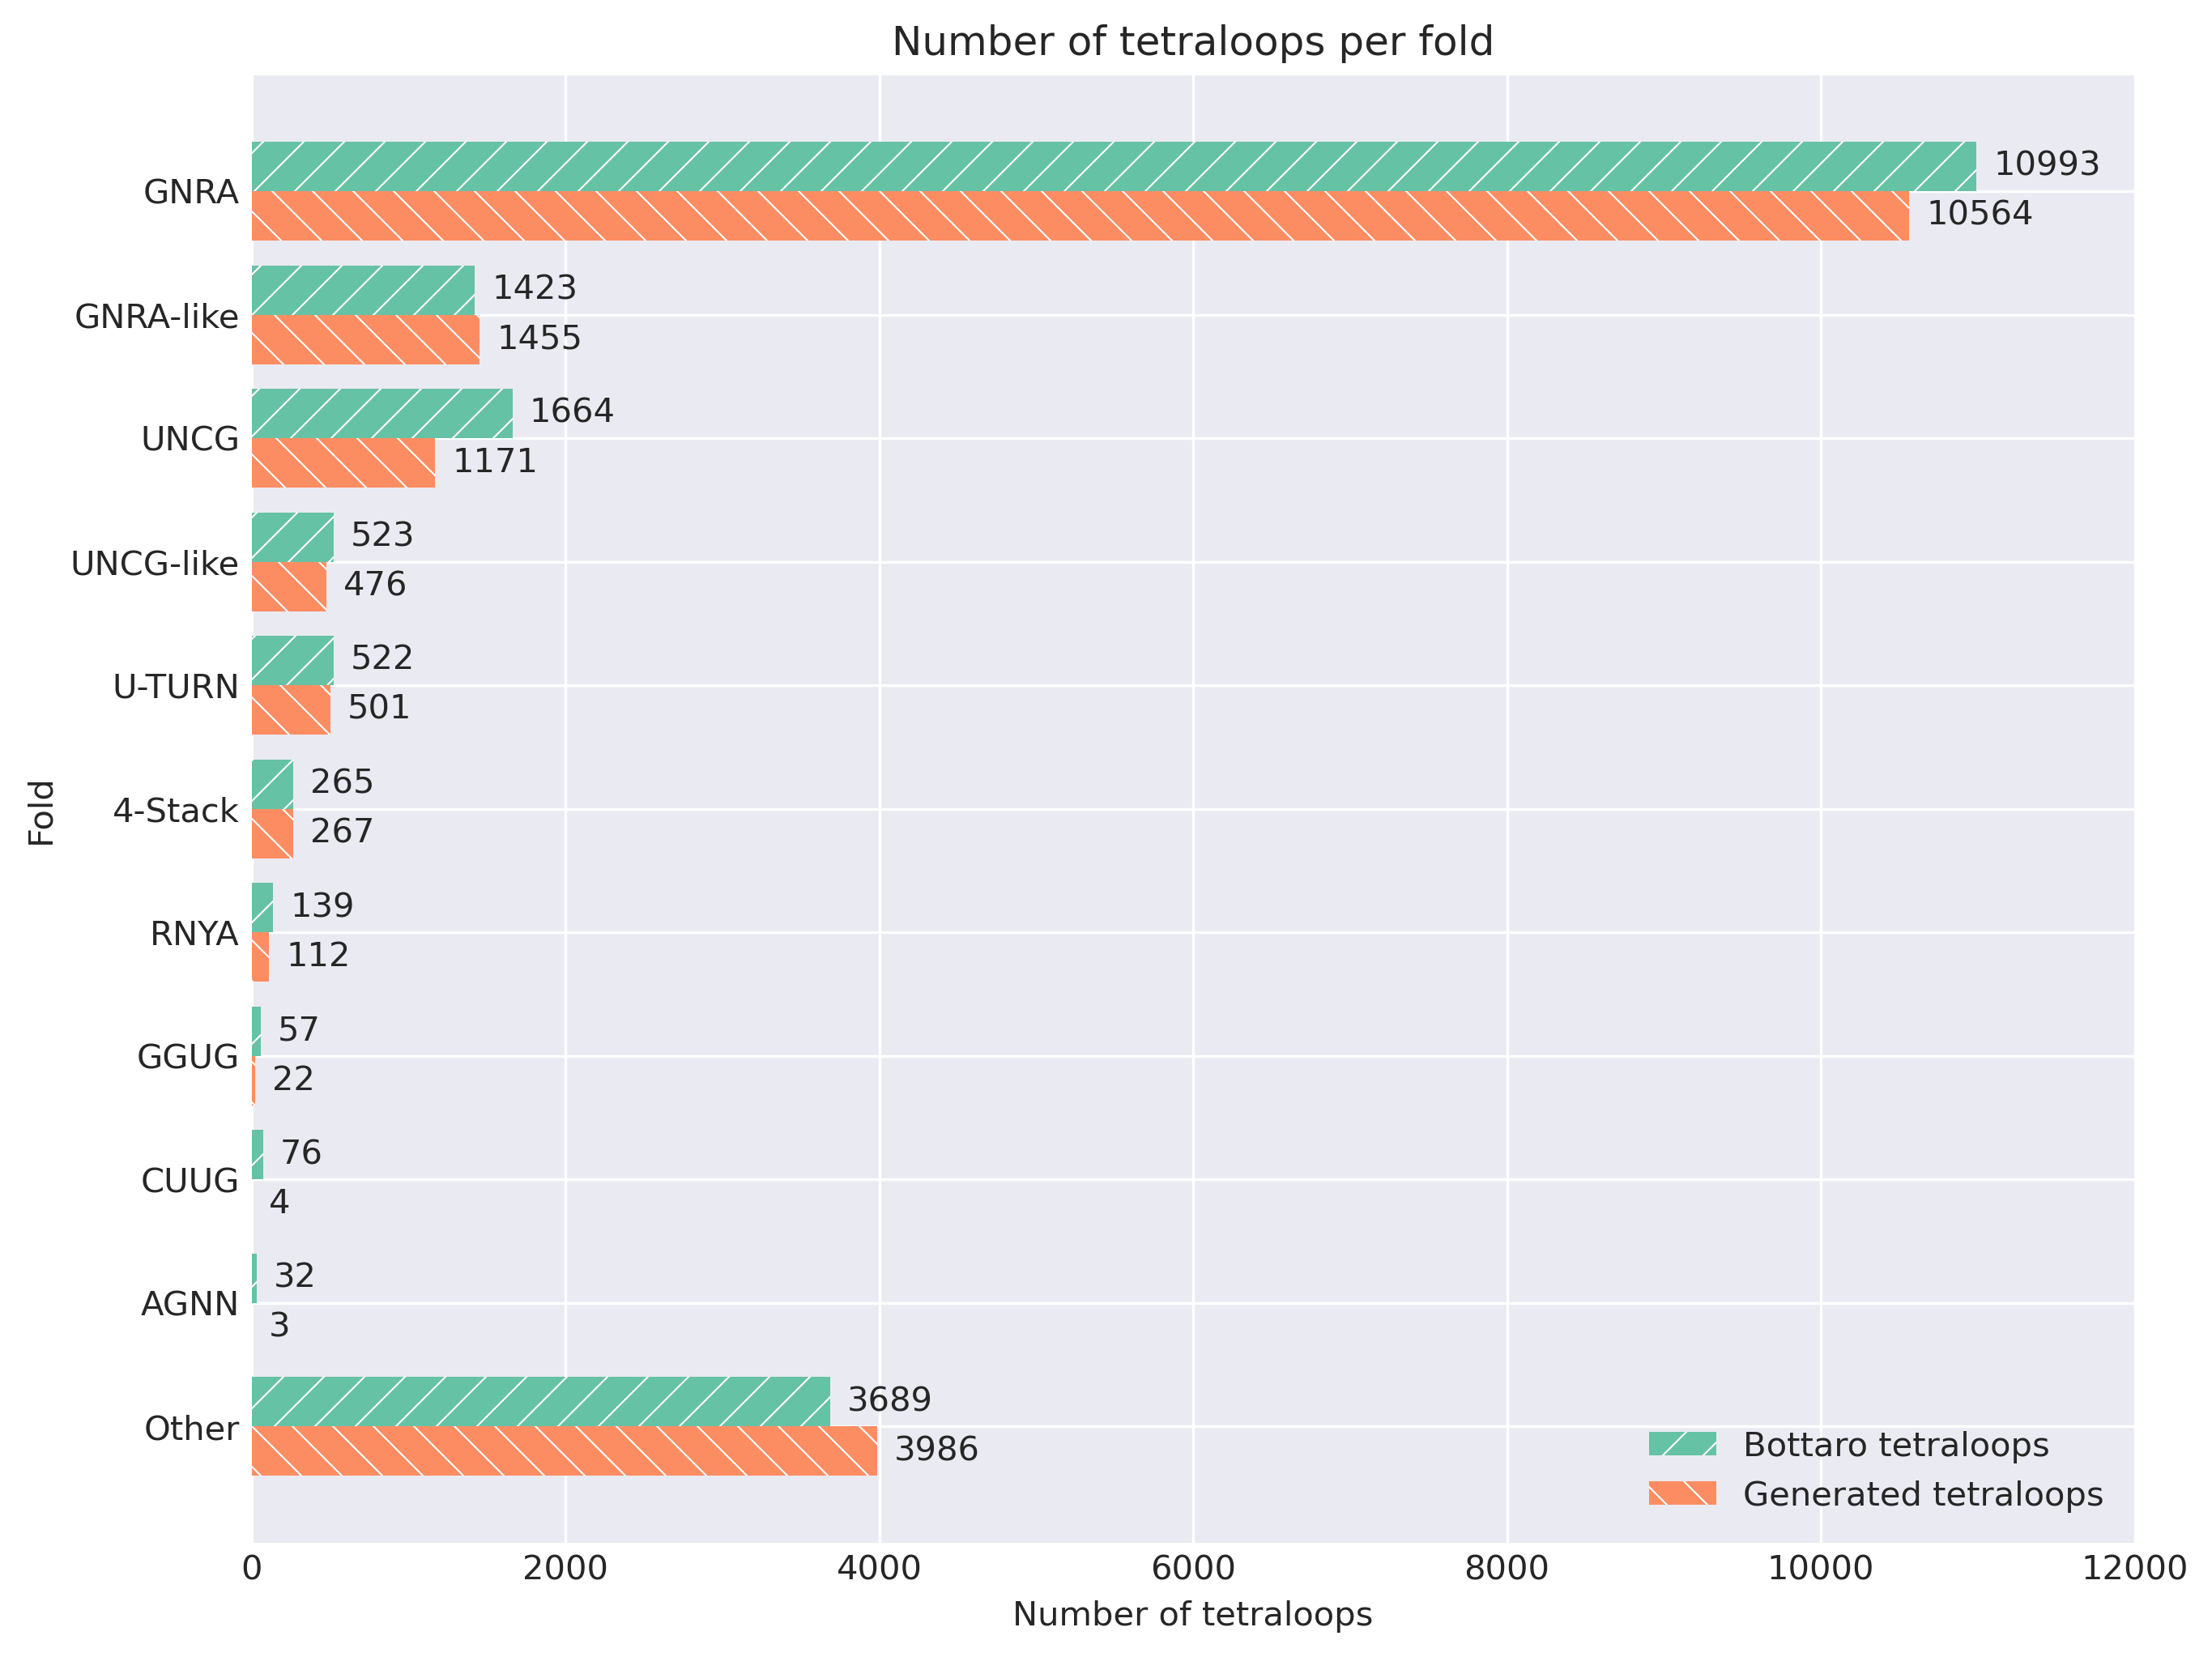

In [59]:
# Fold analysis

height = 0.4

fig, ax = plt.subplots(figsize=(10,8), dpi=300)
ax.set_title("Number of tetraloops per fold")
ax.set_xlabel("Number of tetraloops")
ax.set_ylabel("Fold")
ax.set_xlim([0, 12000])

named_clusters = [i for i in folds.values() if not i.isdigit()]

# Bottaro 
bottaro_data = get_counter_dict([i.clust_id for i in tloops])

bottaro_merged = dict(zip(named_clusters, np.zeros(len(named_clusters))))
bottaro_merged["Other"] = 0
for cluster, count in bottaro_data.items():
    cluster_name = folds[cluster]
    if cluster_name.isdigit():  bottaro_merged["Other"] += count
    else:                       bottaro_merged[folds[cluster]] += count
bottaro_merged = dict(reversed(list(bottaro_merged.items())))

bar = ax.barh(range(len(bottaro_merged)), bottaro_merged.values(), height=height, align="edge", hatch=HATCHES[0])
ax.set_yticks(range(len(bottaro_merged)), labels=bottaro_merged.keys())
ax.bar_label(bar, [int(i) for i in bottaro_merged.values()], padding=5)

# Generated
generated_data = get_counter_dict([i.clust_id for i in fragments_8 if i.clust_id in range(1,45)])

generated_merged = dict(zip(named_clusters, np.zeros(len(named_clusters))))
generated_merged["Other"] = 0
for cluster, count in generated_data.items():
    cluster_name = folds[cluster]
    if cluster_name.isdigit():  generated_merged["Other"] += count
    else:                       generated_merged[folds[cluster]] += count
generated_merged = dict(reversed(list(generated_merged.items())))

bar = ax.barh(range(len(generated_merged)), generated_merged.values(), height=-height, align="edge", hatch=HATCHES[1])
ax.bar_label(bar, [int(i) for i in generated_merged.values()], padding=5)

ax.legend(labels=["Bottaro tetraloops", "Generated tetraloops"], loc = "lower right")
fig.savefig(FIGURES_DIR/"tloops_per_fold.png", bbox_inches='tight', dpi=300)

In [63]:
# Balance (using Shannon entropy index) 0-1

def balance(classes):
    n_total = sum(classes.values())
    n_classes = len(classes)
    H = -sum([(count/n_total) * np.log((count/n_total)) for _, count in classes.items()])
    return H/np.log(n_classes)

print(f"Fragments balance: {balance(get_counter_dict([i.clust_id for i in fragments_8])):.3f}")

print(f"Bottaro tetraloops balance: {balance(get_counter_dict([i.clust_id for i in tloops])):.3f}")
print(f"Generated tetraloops balance: {balance(get_counter_dict([i.clust_id for i in fragments_8 if i.clust_id != 0])):.3f}")

#! class sizes reduced proportionally
#! redundancy reduction has no effect, balance stays the same
#! maybe all clusters have the same proportion of redundancy
#! some clusters more strict

Fragments balance: 0.017
Bottaro tetraloops balance: 0.547
Generated tetraloops balance: 0.549


## Training datasets

In [85]:
# train/dev/test ratios and % positive examples

training_data = {}

for dir in os.listdir(TRAINING_DATA_DIR):
    if os.path.isfile(TRAINING_DATA_DIR/dir): continue
    if dir[-1] == "T": continue

    data_dict = {}
    total = 0
    positives = 0

    for file in os.listdir(TRAINING_DATA_DIR/dir):
        if file.endswith('.csv') or file.endswith('.npz'): continue

        name = file.split("_")[0]
        labels = np.load(TRAINING_DATA_DIR/dir/file)
        data_dict[name] = len(labels)
        
        total += len(labels)
        positives += np.count_nonzero(labels == 1)
    
    data_dict["total"] = total
    data_dict["positive"] = positives
    data_dict = dict(sorted(zip(data_dict.keys(), data_dict.values())))

    data_name = "_".join(dir.split("_")[:2])
    training_data[data_name] = data_dict

training_data = dict(sorted(training_data.items(), key=lambda x: x[0]))
print(f"{'Dataset':<15} | {     'Train':<5} | {     'Dev':<4} | {     'Test':<4} | {     'Total':<5} | {'Positive (%)'}")
print('-'*60)
for key, val in training_data.items():
    pos_percent = val['positive']/val['total']*100
    print(f"{  key:<15} | {val['train']:<5} | {val['dev']:<4} | {val['test']:<4} | {val['total']:<5} | {val['positive']} ({pos_percent:.2f})")
    print('-'*60)

Dataset         | Train | Dev  | Test | Total | Positive (%)
------------------------------------------------------------
clusters_10     | 49506 | 6202 | 6208 | 61916 | 269 (0.43)
------------------------------------------------------------
clusters_12     | 53876 | 6748 | 6756 | 67380 | 334 (0.50)
------------------------------------------------------------
clusters_14     | 55890 | 7000 | 7008 | 69898 | 350 (0.50)
------------------------------------------------------------
clusters_16     | 57364 | 7184 | 7193 | 71741 | 365 (0.51)
------------------------------------------------------------
clusters_18     | 58581 | 7337 | 7346 | 73264 | 374 (0.51)
------------------------------------------------------------
clusters_20     | 59613 | 7465 | 7472 | 74550 | 376 (0.50)
------------------------------------------------------------
clusters_22     | 60522 | 7579 | 7586 | 75687 | 389 (0.51)
------------------------------------------------------------
clusters_24     | 61353 | 7682 | 7689 